In [7]:
%matplotlib inline
from pylab import *
import numpy as np
import matplotlib.pyplot as plt
import ctypes
import os
from ctypes import *

In [8]:
os.system("rm eq_flick.so")
os.system("gcc -shared -o eq_flick.so -fPIC eq_flick.c")

lib = CDLL("./eq_flick.so")

lib.flick_equation_1d.argtypes = [POINTER(c_double), POINTER(c_double),POINTER(POINTER(c_double)), c_int, c_int, c_double, c_double,c_int]
lib.flick_equation_1d.restype = None


In [9]:
b=2                 #prenderò misure ogni b^i 
n=15                #il numero di i che voglio
nx = 100            # Numero di punti spaziali
nt = b**n           # Numero di passi temporali
L = 1.0             # Lunghezza catena
alpha = 1.0         #coeff diffusione
dx = L / (nx - 1) 
dt = 0.0000001
rho0 = 0.5          # densità iniziale 

# Condizioni iniziali
x = np.linspace(0, L, nx)
rho = np.full(nx, rho0)             # cond iniziale è uniforme
rho_evo = np.full((n+1, nx), rho0)  # Condizione iniziale è uniforme
v = np.sin(x * 10 * L * np.pi) + 2  # 10 per avere tante osc.
D = v ** 2 / alpha


# per eq del calore si deve avere alpha*dt/dx**2 < 0.5 per essere stabile eulero
# Controlla il valore del parametro
a = max(D) * dt / dx ** 2
if a > 0.5:
    print("Errore: il rapporto alpha*dt/dx**2 non può essere maggiore di 0.5, altrimenti Eulero diverge. Qui vale", np.round(a, 2))
    sys.exit(1)

rho_ptr = rho.ctypes.data_as(POINTER(c_double))
D_ptr = D.ctypes.data_as(POINTER(c_double))

rho_evo_ptr = (POINTER(c_double) * (n+1))() #n+1 perchè caso 0 lo riempio con cond iniziale
for i in range(n+1):
    rho_evo_ptr[i] = (c_double * nx)(*rho_evo[i])

#integrazione
lib.flick_equation_1d(rho_ptr, D_ptr, rho_evo_ptr, nx, nt, dx, dt,b)

#riconverto risultati
rho_result = np.ctypeslib.as_array(rho_ptr, shape=(nx,))
rho_evo_result = np.full((n+1, nx),rho0)
for i in range(n+1): 
    rho_evo_result[i] = np.ctypeslib.as_array(rho_evo_ptr[i], shape=(nx,))




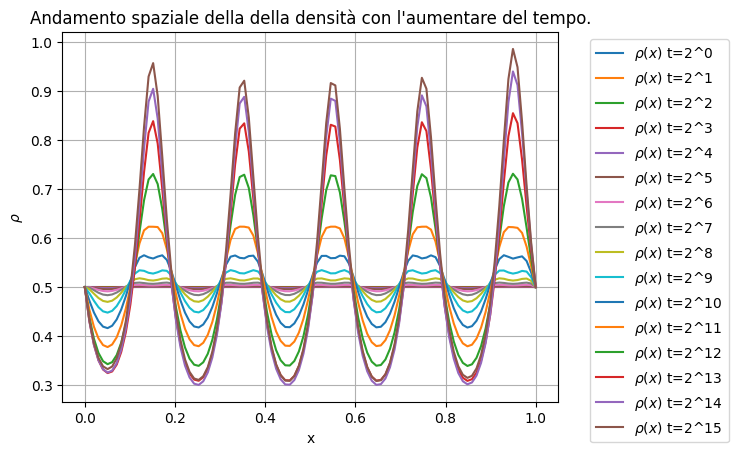

In [10]:
#plot andamento temp.
for i in range(n+1):
    plt.plot(x, rho_evo_result[i], label=r'$\rho(x)$ t={0}^{1}'.format(b,i))
plt.xlabel(r'x')
plt.ylabel(r'$\rho$')
plt.title("Andamento spaziale della della densità con l'aumentare del tempo.")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
#plot plt.show()

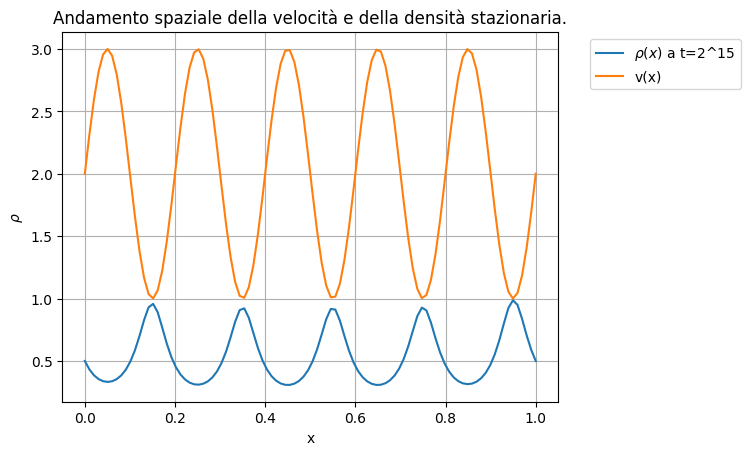

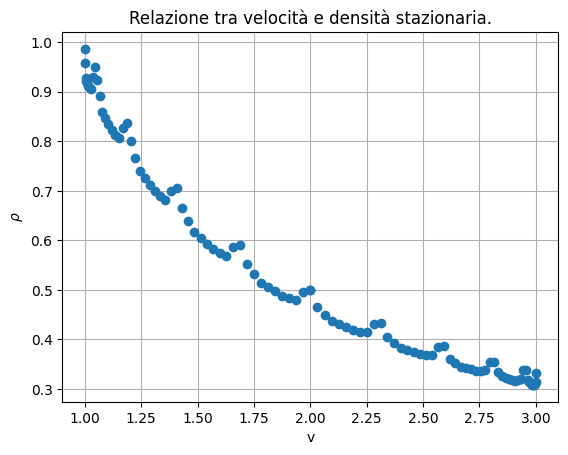

Coefficiente angolare (m): -0.9993505197641782
Intercetta (q): -0.06213450191389438


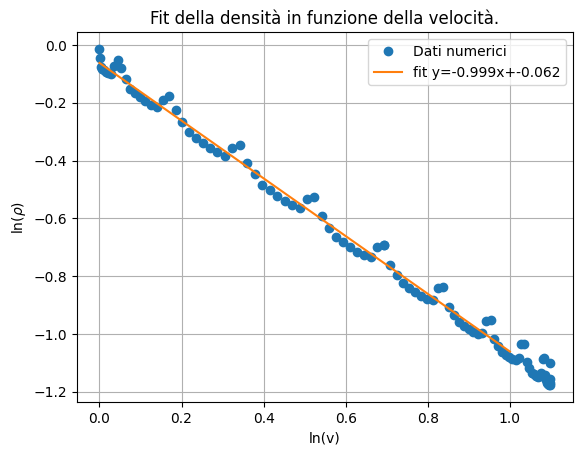

In [11]:
#plot x e v 
plt.plot(x, rho_evo_result[n], label=r'$\rho(x)$ a t={0}^{1}'.format(b,n))
plt.plot(x, v,label='v(x)')
plt.xlabel(r'x')
plt.ylabel(r'$\rho$')
plt.title('Andamento spaziale della velocità e della densità stazionaria.')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()
plt.show()

plt.plot(v, rho_evo_result[n],"o")
plt.xlabel(r'v')
plt.ylabel(r'$\rho$')
plt.title('Relazione tra velocità e densità stazionaria.')
plt.grid()
plt.show()

#fit 
coefficients = np.polyfit(np.log(v), np.log(rho_evo_result[n]), 1)
m, q = coefficients
print(f"Coefficiente angolare (m): {m}")
print(f"Intercetta (q): {q}")

plt.plot(np.log(v), np.log(rho_evo_result[n]), "o", label="Dati numerici")
plt.plot(x, m * x + q, label=f"fit y={np.round(m,3)}x+{np.round(q,3)}")
plt.xlabel(r'ln(v)')
plt.ylabel(r'ln($\rho$)')
plt.title('Fit della densità in funzione della velocità.')
plt.legend()
plt.grid()
plt.show()